In [1]:
import logging

import numpy as np
import pandas as pd
import geopandas as gpd
import pyarrow.compute as pc
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
from scipy.spatial import KDTree

from src.datalake import Datalake

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
plt.style.use('bmh')


def initialize_figure(w: int = 14, h: int = 10) -> any:
    return plt.subplots(figsize=(w, h))

In [2]:
data = Datalake("../lake")
state_geoms = data.query_states()

scope_states = ["California"]
scope_multipoly = state_geoms[state_geoms.name.isin(scope_states)].geometry.iloc[0]

In [3]:
def load_datasets_by_scope_poly(
        scope_poly: MultiPolygon,
        perimeter_id_set: set[str] | None = None,
        station_id_set: set[str] | None = None,
) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    perimeters = data.query_fire_perimeter()
    stations = data.query_stations()

    if perimeter_id_set is not None:
        scoped_perimeters = perimeters[perimeters["OBJECTID"].isin(perimeter_id_set)]
    else:
        scoped_perimeters = perimeters[perimeters.geometry.intersects(scope_poly)]

    if station_id_set is not None:
        scoped_stations = stations[stations["station_id"].isin(station_id_set)]
    else:
        scoped_stations = stations[stations.geometry.within(scope_poly)]

    return scoped_perimeters, scoped_stations


perimeters, stations = load_datasets_by_scope_poly(
    scope_poly=scope_multipoly,
    # Use *_id_set=None to automatically do the computation
    perimeter_id_set=pd.read_csv("california_perimeters_ids.csv")["OBJECTID"],
    station_id_set=pd.read_csv("california_station_ids.csv")["station_id"]
)

perimeters.dropna(subset=["DISCOVERYDATETIME"], inplace=True)

In [4]:
perimeters.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 466 entries, 13000 to 13499
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   OBJECTID           466 non-null    int32              
 1   GLOBALID           466 non-null    object             
 2   FIREOCCURID        150 non-null    object             
 3   CN                 6 non-null      object             
 4   REVDATE            466 non-null    datetime64[ms, UTC]
 5   FIRENAME           466 non-null    object             
 6   COMPLEXNAME        15 non-null     object             
 7   FIREYEAR           466 non-null    float64            
 8   UNIQFIREID         452 non-null    object             
 9   SOFIRENUM          240 non-null    object             
 10  LOCALFIRENUM       34 non-null     object             
 11  SECURITYID         124 non-null    object             
 12  DISCOVERYDATETIME  466 non-null    object

In [5]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3157 entries, 56821 to 128741
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   station_id  3157 non-null   object  
 1   latitude    3157 non-null   float64 
 2   longitude   3157 non-null   float64 
 3   elevation   3157 non-null   float64 
 4   name        3157 non-null   object  
 5   geometry    3157 non-null   geometry
dtypes: float64(3), geometry(1), object(2)
memory usage: 172.6+ KB


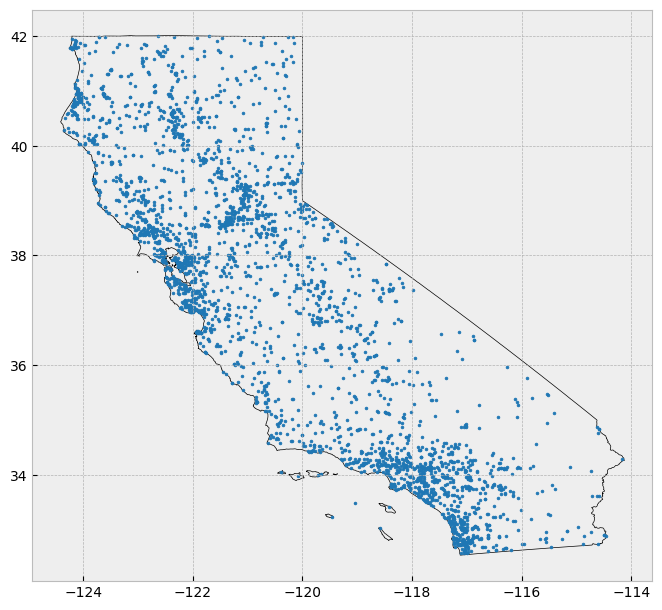

In [6]:
# Build spatial query tree for fast k-NN lookup, kd tree is good for low-dimensional and static data
station_xy = np.column_stack((stations.longitude, stations.latitude))
tree = KDTree(station_xy)

fig, ax = plt.subplots(figsize=(8, 8))

for geom in scope_multipoly.geoms:
    xs, ys = geom.exterior.xy
    ax.fill(xs, ys, alpha=1, ec="black", fc="None")

ax.scatter(stations.longitude, stations.latitude, s=4, c="tab:blue")
ax.set_aspect('equal', adjustable='box')

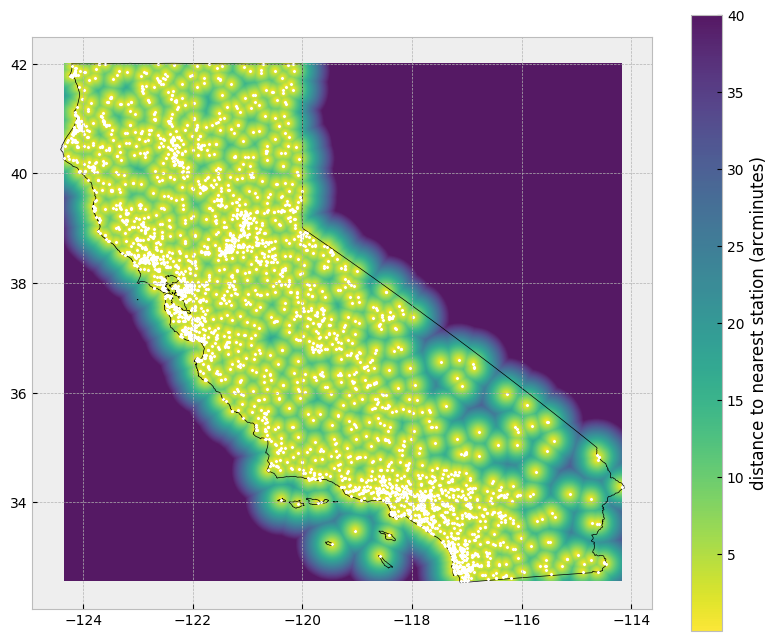

In [7]:
xmin, xmax = stations.longitude.min(), stations.longitude.max()
ymin, ymax = stations.latitude.min(), stations.latitude.max()

grid_res = 512
lon_grid = np.linspace(xmin, xmax, grid_res)
lat_grid = np.linspace(ymin, ymax, grid_res)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
grid_points = np.column_stack((lon_mesh.ravel(), lat_mesh.ravel()))

# Compute distances to the nearest station
dists, _ = tree.query(grid_points)
dists *= 60  # Convert to arcminutes
dist_grid = dists.reshape(grid_res, grid_res)

fig, ax = plt.subplots(figsize=(10, 8))
for geom in scope_multipoly.geoms:
    xs, ys = geom.exterior.xy
    ax.fill(xs, ys, alpha=1, ec="black", fc="None")
c = ax.imshow(dist_grid, extent=[xmin, xmax, ymin, ymax], origin="lower", cmap="viridis_r", alpha=0.9, vmax=40)
ax.scatter(stations.longitude, stations.latitude, s=1, c="white", marker="x")
fig.colorbar(c, ax=ax, label="distance to nearest station (arcminutes)")
ax.set_aspect('equal', adjustable='box')

In [8]:
# Expand the geometry of a fire perimeter to get a geometry that is within some distance from the fire
# This can be done by doing a minkowski sum of the perimeter with a circle radius n
minkowski_sum_radius_deg = 0.25  # 0.25 degrees = around 25km
perimeters["expanded_geometry"] = perimeters.geometry.buffer(
    distance=minkowski_sum_radius_deg, resolution=2
)
# This takes a while (~1 min), larger expansions take less time up to a certain point
# Ignore warning, we don't really care how the curvature of the planet in California differs from the
# overall ellipsoidal curvature of the Earth

# We can then find all weather stations inside the fire's expanded perimeter

C:\Users\katac\AppData\Local\Temp\ipykernel_16044\1616303943.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  perimeters["expanded_geometry"] = perimeters.geometry.buffer(


In [9]:
# Naive implementation is O(nm), takes around 2s per station id, for 3.2k stations ids, so around 2 hours
#
### perimeter_stations = {row.OBJECTID: [] for _, row in perimeters.iterrows()}
###
### for i, station_row in stations.iterrows():
###     station_id, pt = station_row.station_id, station_row.geometry
###     if not isinstance(pt, Point):
###         continue
###
###     for j, perimeter_row in perimeters.iterrows():
###         sid, poly = perimeter_row.OBJECTID, perimeter_row.geometry
###         if isinstance(poly, (Polygon, MultiPolygon)) and poly.contains(pt):
###             perimeter_stations[sid].append(station_id)wit


# I use an optimized approach with a spatial tree instead, O((m + n) log n), n is number of fire perimeters
# Speed up factor of 1000, finishes in around 2-3 seconds
### import rtree
### rt = rtree.index.Index()
###
### poly_dict = {}
###
### print("Constructing R-tree from polygon bounding boxes")
### for idx, (_, row) in enumerate(perimeters.iterrows()):
###     if idx % 5000 == 0: print(f"{idx} / {len(perimeters)} multi-polys inserted")
###
###     sid, poly = row.OBJECTID, row.geometry
###     if isinstance(poly, (Polygon, MultiPolygon)):
###         rt.insert(sid, poly.bounds)
###         poly_dict[sid] = poly
###
perimeter_stations = {sid: [] for sid in perimeters["OBJECTID"]}
### print("Associating weather stations to fire perimeters")
### for idx, (_, row) in enumerate(stations.iterrows()):
###     if idx % 1000 == 0: print(f"{idx} / {len(stations)} stations processed")
###
###     station_id, pt = row.station_id, row.geometry
###     # Find candidate perimeters using R-tree bounding box lookup
###     candidate_polys = [sid for sid in rt.intersection((pt.x, pt.y, pt.x, pt.y))]
###
###     # Validate using actual point-in-polygon test
###     for sid in candidate_polys:
###         if poly_dict[sid].contains(pt):
###             perimeter_stations[sid].append(station_id)

# Never mind, just do this, runs in like milliseconds
perimeter_stations |= (
    gpd
    .sjoin(
        left_df=stations.copy(),
        right_df=perimeters.copy().set_geometry("expanded_geometry"),
        how="left",
        predicate="within"
    )
    .groupby("OBJECTID")["station_id"]
    .apply(list).to_dict()
)

In [10]:
perimeters[perimeters["OBJECTID"].isin([k for k, v in perimeter_stations.items() if len(v) == 0])]

,OBJECTID,GLOBALID,FIREOCCURID,CN,REVDATE,FIRENAME,COMPLEXNAME,FIREYEAR,UNIQFIREID,SOFIRENUM,...,FEATURECAT,FIRERPTQC,DBSOURCEID,DBSOURCEDATE,ACCURACY,SHAPE,SHAPEAREA,SHAPELEN,geometry,expanded_geometry
13317,21901906,{BCC82D3E-341E-4A00-B56E-748D8C405A2B},9D060927-6532-4F1A-B4A3-282FA26F01C5,None,2022-03-31 11:14:09+00:00,Little Marble,None,2021.0,2021-CAKNF-007809,None,...,Final Wildfire Perimeter,Yes,05,2024-04-17 04:05:52+00:00,NaN,None,0.000006,0.049674,"POLYGON ((-123.19875 41.5572, -123.1988 41.557...","POLYGON ((-123.44925 41.54904, -123.45119 41.5..."
13489,21902078,{2AFB2897-F1B9-45BF-A3F8-1E18459D264A},None,None,2019-01-02 00:00:00+00:00,GOLDEN,None,2007.0,00000000,0000,...,Final Wildfire Perimeter,No,05,2024-04-17 04:05:53+00:00,NaN,None,0.000805,0.155169,"POLYGON ((-116.59689 36.04627, -116.59754 36.0...","POLYGON ((-116.86168 36.01737, -116.86405 36.0..."


In [ ]:
data.query_ghcnd(pc.scalar(True))
""